In [26]:
#!pip install --upgrade gensim
import gensim
import pandas as pd
import nltk
import numpy as np

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/calvinlu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [282]:
import re

# Text for fitting PCA. Realistically, should be corpus of text somewhat related to what we want to sonify. Should probably be a superset of the text we want to sonify. 
# Might be worth looking into results with completely unrelated text as well. 
pca_text="Word embedding is the collective name for a set of language modeling and feature learning techniques in natural language processing where words or phrases from the vocabulary are mapped to vectors of real numbers. Conceptually it involves a mathematical embedding from a space with many dimensions per word to a continuous vector space with a much lower dimension.The use of multi-sense embeddings is known to improve performance in several NLP tasks, such as part-of-speech tagging, semantic relation identification, and semantic relatedness. However, tasks involving named entity recognition and sentiment analysis seem not to benefit from a multiple vector representation."
# Text we want to sonify
son_text = "Between shadow and space, between harnesses and virgins, Endowed with a singular heart and fatal dreams, Impetuously pale, withered in the forehead and in mourning like an angry widower every day of my Life, Oh, for every drink of invisible water I swallow drowsily and with every sound I take in, trembling, I feel the same missing thirst and the same cold fever, an ear being born, an indirect anguish, As if thieves were arriving, or ghosts, And inside a long, deep, hollow shell, Like a humiliated waiter, like a bell gone a bit Hoarse, Like an old mirror, like the smell of an empty house Where the guests come back at night hopelessly drunk, And there’s an odor of clothes thrown on the floor, and An absence of flowers — or maybe somehow a little less melancholic — But the truth is, suddenly, the wind lashing my chest, The infinitely dense nights dropped into my bedroom, The noise of a day burning with sacrifice Demand what there is in me of the prophetic, with Melancholy And there’s a banging of objects that we call without being Answered, And a restless motion, and a muddled name."

def tokenize(text):
    text=re.sub(r"[^.A-Za-z]",' ',text)
    sentence=text.split('.')
    tokens=[nltk.word_tokenize(words) for words in sentence]
    return sentence, tokens

_, pca_tokens = tokenize(pca_text)
son_sentence, son_tokens = tokenize(son_text)
#tokens

In [29]:
filename = './GoogleNews-vectors-negative300.bin' # use your own file path/name
model = gensim.models.KeyedVectors.load_word2vec_format(filename, binary=True)

In [30]:
# Build set of words that exist in vocabulary 
# Words that aren't in vocab will just be ignored for the time being. 
def get_tokens(model, tokens):
    viable_vocab_list = set()
    for i in range(len(tokens)):
        for j in range(len(tokens[i])):
            try:
                if tokens[i][j] in model.wv.key_to_index:
                    viable_vocab_list.add(tokens[i][j])
            except:
                if tokens[i][j] in model.key_to_index:
                    viable_vocab_list.add(tokens[i][j])
    return viable_vocab_list

viable_vocab = get_tokens(model, pca_tokens)

In [31]:
# Embedding representations of words to build PCA. 
values = model[list(viable_vocab)]

0 0
5 0.12850961346645667
10 0.1989332283385346
15 0.2503571166810301
20 0.29198622530188806
25 0.326505351015906
30 0.3575538886145982
35 0.3856978425278153
40 0.4112050361912773
45 0.4349288760792872
50 0.4571615522781585
55 0.47797835213579937
60 0.49784495061563483
65 0.51673290645287
70 0.5347076660011935
75 0.5519014659041634
80 0.5683142253963844
85 0.5840632144859809
90 0.5993225719805497
95 0.6140462702196515
100 0.6283032295458519


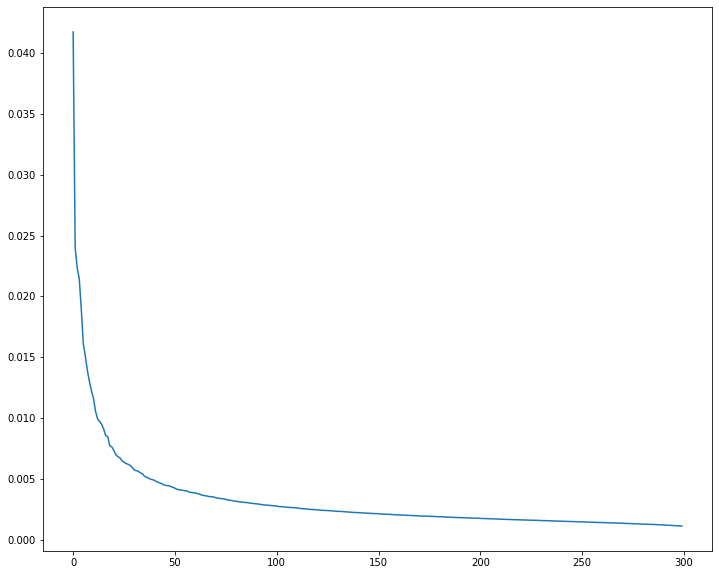

In [32]:
# just testing. 
def peek_dimensionality(model, values):
    pca = PCA() # full dimensionality
    try:
        pca.fit(model[values])
    except: 
        pca.fit(model.wv[values])
    
    # How many dimensions should we keep? 
    plt.plot(pca.explained_variance_ratio_)
    for i in range(0,101,5):
        print(i, sum(pca.explained_variance_ratio_[:i]))
    
    return pca, pca.explained_variance_ratio_

pca, variances = peek_dimensionality(model, model.index_to_key)

# that's a lot of variance left unexplained, but note that much of it with be irrelevant for our prose.
# what if we only fit pca to a much smaller poetry dataset? 

In [34]:
# from https://www.kaggle.com/danofer/poetry2vec-word-embeddings
df = pd.read_csv("../Gutenberg-Poetry.csv",
                 usecols=["s"]).drop_duplicates().rename(columns={"s":"text"})
df = df.loc[df["text"].str.split().str.len()>1]

In [35]:
from gensim.utils import simple_preprocess
df['text'] = df['text'].apply(lambda x: simple_preprocess(x, True, 2, 420))
sentences = df['text']

In [36]:
poetry_vocab = set()
for sentence in sentences: 
    for item in sentence:
        poetry_vocab.add(item)

In [37]:
poetry_tokens = get_tokens(model, [list(poetry_vocab)])
print(len(poetry_tokens), len(poetry_vocab))

60266 234066


0 0
5 0.1124917883425951
10 0.1735073085874319
15 0.2210384663194418
20 0.2612977223470807
25 0.29616964887827635
30 0.3274520365521312
35 0.35585127817466855
40 0.3818652746267617
45 0.40594091871753335
50 0.4285932001657784
55 0.4501196276396513
60 0.47050270112231374
65 0.48989271256141365
70 0.508473384892568
75 0.5263335888739675
80 0.5435004141181707
85 0.5600029202178121
90 0.57586132385768
95 0.591255419421941
100 0.6062173231039196


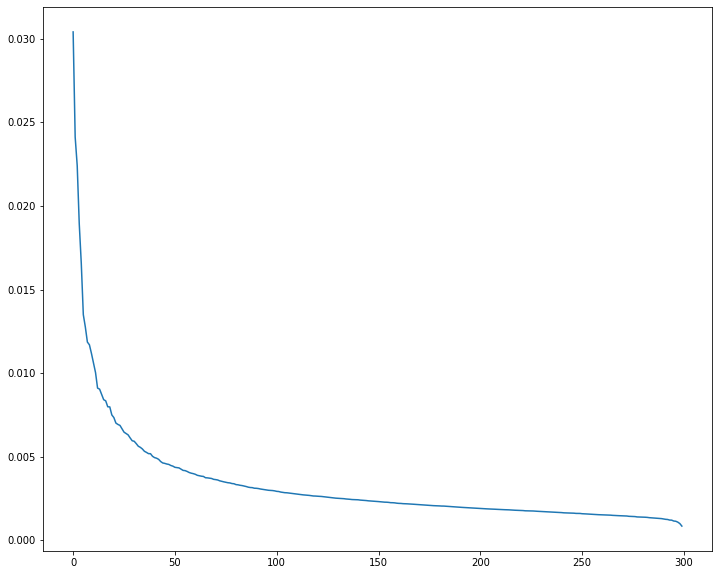

In [38]:
# Does the subspace act nicer if we only look at poetry? 
pca, variances = peek_dimensionality(model, poetry_tokens) 
# This appears even worse. 

In [39]:
#model_poetry = gensim.models.Word2Vec(sentences, vector_size = 200, workers = 8)
#word_vectors = model_poetry.wv
#word_vectors.save('model_poetry.wordvectors')
model = gensim.models.KeyedVectors.load('model_poetry.wordvectors', mmap = 'r')

In [40]:
len(model.key_to_index)

65613

0 0
5 0.27524217373838594
10 0.41559633321274425
15 0.5119611238944056
20 0.5774398207877752
25 0.6264993276308393
30 0.6654079406267812
35 0.6996308956595726
40 0.7285603722554459
45 0.7533431967285643
50 0.7754355406630594
55 0.7952599531469927
60 0.8130683362721942
65 0.8291617985508339
70 0.8436942936487304
75 0.85709905036292
80 0.8692733353335808
85 0.8805998760209183
90 0.8908989961592574
95 0.9006459244123692
100 0.9097951058862721


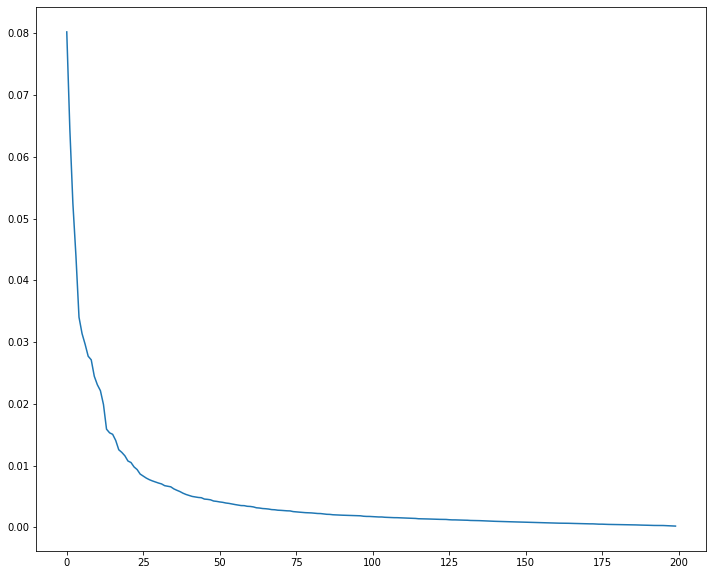

In [41]:
_, _ = peek_dimensionality(model, get_tokens(model, [list(poetry_vocab)]))

In [43]:
num_components = 100 # playing around with components
pca = PCA(n_components=num_components)

# Fit PCA with sample corpus. We *could* do this with the entire vocab list rather than
# the sample text, but unsure if that's a good idea. 
pca.fit(model[model.index_to_key])
sum(pca.explained_variance_ratio_[:num_components])

0.9087649156793739

In [65]:
print(pca.explained_variance_ratio_)

[0.08022904 0.06456202 0.05248176 0.04394239 0.03404525 0.03137837
 0.02965741 0.02772071 0.0271337  0.02447336 0.02310417 0.02214106
 0.01990152 0.01590677 0.01531773 0.01507676 0.0140878  0.01257444
 0.01214676 0.01159731 0.01075434 0.01050702 0.00979379 0.00937044
 0.00863718 0.00831138 0.00798607 0.00773052 0.00752805 0.00735518
 0.00718355 0.00704199 0.00676009 0.00666423 0.00657532 0.00624057
 0.00601245 0.00580467 0.00554086 0.00533267 0.00516976 0.00501756
 0.00493665 0.00485104 0.00480902 0.00458882 0.00454468 0.00446928
 0.00427447 0.00421556 0.00412622 0.00405982 0.00395336 0.00389194
 0.00379164 0.00370161 0.00361937 0.00353626 0.00352634 0.00342087
 0.00339212 0.0033204  0.00317849 0.00313546 0.0030565  0.00302377
 0.00297149 0.00287731 0.00285655 0.00278423 0.00275952 0.00270856
 0.00268504 0.00266794 0.00255611 0.00250131 0.00244982 0.00241096
 0.00238297 0.0023595  0.00233279 0.00228023 0.00224319 0.00222676
 0.00215511 0.00210456 0.00207562 0.00203379 0.00198323 0.0019

In [45]:
#values_pca = pca.transform(values)
values_pca = pca.transform(model[model.index_to_key][:200])

# Plot first 2 components of text used to generate pca fit
neww_X = values_pca[:, :2]

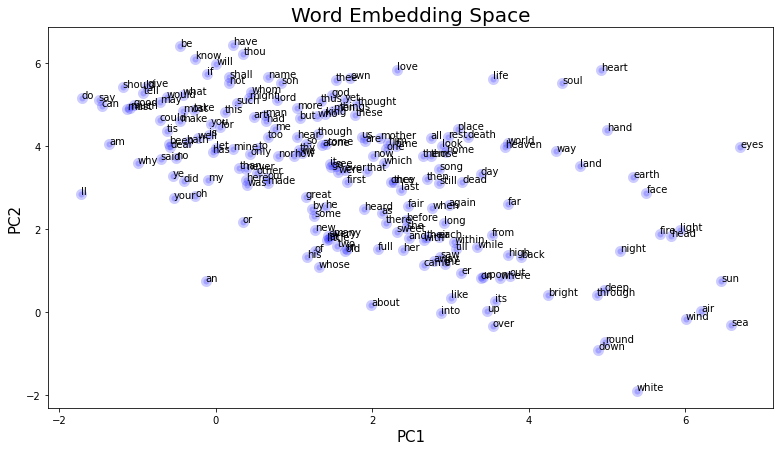

In [50]:
def plot_pca(neww_X, viable_vocab):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(13,7))
    plt.scatter(neww_X[:,0],neww_X[:,1],linewidths=5,color='blue', alpha=0.2)
    plt.xlabel("PC1",size=15)
    plt.ylabel("PC2",size=15)
    plt.title("Word Embedding Space",size=20)
    vocab=list(viable_vocab)
    for i, word in enumerate(vocab):
      plt.annotate(word,xy=(neww_X[i,0],neww_X[i,1]))
#plot_pca(neww_X, viable_vocab)
plot_pca(neww_X, model.index_to_key[:200])

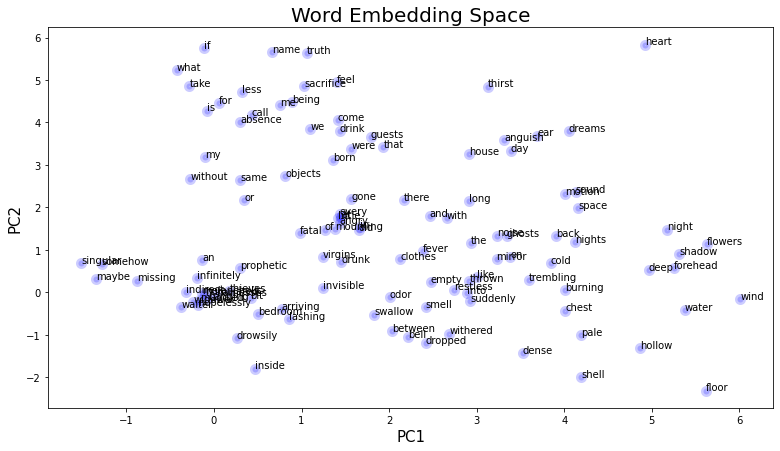

In [51]:
# Generate PCA representations of text we'd like to sonify.
son_viable_vocab = get_tokens(model, son_tokens)
son_values = model[list(son_viable_vocab)]
son_values_pca = pca.transform(son_values)
son_X = son_values_pca[:, :2]
plot_pca(son_X, son_viable_vocab)

# Seems like a pretty poor representation in this example, which is pretty expected since the pca was fit on
# a small & unrelated sample of text

In [52]:
son_dict = {}
for i, word in enumerate(list(son_viable_vocab)): 
    son_dict[word] = son_values_pca[i]

In [277]:
print(son_viable_vocab)

{'guests', 'virgins', 'lashing', 'motion', 'thieves', 'invisible', 'on', 'empty', 'suddenly', 'fever', 'thrown', 'melancholic', 'water', 'born', 'humiliated', 'fatal', 'somehow', 'that', 'burning', 'maybe', 'if', 'the', 'anguish', 'an', 'without', 'deep', 'at', 'chest', 'heart', 'ghosts', 'call', 'trembling', 'clothes', 'objects', 'house', 'shell', 'and', 'take', 'long', 'bell', 'bedroom', 'odor', 'into', 'forehead', 'angry', 'waiter', 'is', 'of', 'there', 'noise', 'floor', 'drowsily', 'banging', 'my', 'muddled', 'for', 'we', 'restless', 'infinitely', 'same', 'day', 'feel', 'absence', 'missing', 'mirror', 'being', 'were', 'mourning', 'hopelessly', 'between', 'swallow', 'singular', 'what', 'sound', 'shadow', 'prophetic', 'hollow', 'ear', 'smell', 'less', 'indirect', 'little', 'drink', 'pale', 'me', 'in', 'name', 'dropped', 'old', 'space', 'sacrifice', 'every', 'widower', 'inside', 'with', 'nights', 'thirst', 'arriving', 'night', 'dense', 'gone', 'back', 'bit', 'wind', 'harnesses', 'drun

In [283]:
sonify_list = []
word_tracker = []
son_tokens[0] = [x.lower() for x in son_tokens[0]]
for word in son_tokens[0]: 
    try: 
        sonify_list.append(son_dict[word])
        word_tracker.append(word)
    except:
        # do we want a filler or just move on to the next word?
        continue
print(son_dict.keys())

dict_keys(['guests', 'virgins', 'lashing', 'motion', 'thieves', 'invisible', 'on', 'empty', 'suddenly', 'fever', 'thrown', 'melancholic', 'water', 'born', 'humiliated', 'fatal', 'somehow', 'that', 'burning', 'maybe', 'if', 'the', 'anguish', 'an', 'without', 'deep', 'at', 'chest', 'heart', 'ghosts', 'call', 'trembling', 'clothes', 'objects', 'house', 'shell', 'and', 'take', 'long', 'bell', 'bedroom', 'odor', 'into', 'forehead', 'angry', 'waiter', 'is', 'of', 'there', 'noise', 'floor', 'drowsily', 'banging', 'my', 'muddled', 'for', 'we', 'restless', 'infinitely', 'same', 'day', 'feel', 'absence', 'missing', 'mirror', 'being', 'were', 'mourning', 'hopelessly', 'between', 'swallow', 'singular', 'what', 'sound', 'shadow', 'prophetic', 'hollow', 'ear', 'smell', 'less', 'indirect', 'little', 'drink', 'pale', 'me', 'in', 'name', 'dropped', 'old', 'space', 'sacrifice', 'every', 'widower', 'inside', 'with', 'nights', 'thirst', 'arriving', 'night', 'dense', 'gone', 'back', 'bit', 'wind', 'harness

In [290]:
print(son_tokens[0])
print(word_tracker)
print(len(word_tracker))
print(len(sonify_list))

['between', 'shadow', 'and', 'space', 'between', 'harnesses', 'and', 'virgins', 'endowed', 'with', 'a', 'singular', 'heart', 'and', 'fatal', 'dreams', 'impetuously', 'pale', 'withered', 'in', 'the', 'forehead', 'and', 'in', 'mourning', 'like', 'an', 'angry', 'widower', 'every', 'day', 'of', 'my', 'life', 'oh', 'for', 'every', 'drink', 'of', 'invisible', 'water', 'i', 'swallow', 'drowsily', 'and', 'with', 'every', 'sound', 'i', 'take', 'in', 'trembling', 'i', 'feel', 'the', 'same', 'missing', 'thirst', 'and', 'the', 'same', 'cold', 'fever', 'an', 'ear', 'being', 'born', 'an', 'indirect', 'anguish', 'as', 'if', 'thieves', 'were', 'arriving', 'or', 'ghosts', 'and', 'inside', 'a', 'long', 'deep', 'hollow', 'shell', 'like', 'a', 'humiliated', 'waiter', 'like', 'a', 'bell', 'gone', 'a', 'bit', 'hoarse', 'like', 'an', 'old', 'mirror', 'like', 'the', 'smell', 'of', 'an', 'empty', 'house', 'where', 'the', 'guests', 'come', 'back', 'at', 'night', 'hopelessly', 'drunk', 'and', 'there', 's', 'an',

In [293]:
import sys
from importlib import reload
import subprocess as sp
from subprocess import Popen
import os
        
import notepicker
import syllables
import writeCmixSco_GRAN_v2 as wRT_gran
import writeCmixSco_WT_ac as wRT_wt
        
num_components = 25

class word2sound():
    import syllables 
    
    def __init__(self, sonify_list, sonify_words, name, target_index):
        import sys
        from importlib import reload
        import subprocess as sp
        from subprocess import Popen
        import os
        
        import notepicker
        import syllables
        import writeCmixSco_GRAN_v2 as wRT_gran
        import writeCmixSco_WT_ac as wRT_wt
        sys.path.append('./modules/')
            
        # ======================================================
        # autocheck for your RTcmix installation type: 
        cmixStatus, cmixResult = sp.getstatusoutput("CMIX")
        if cmixStatus == 0:
            cmixInstalled = True
            print("CMIX found.")
        else:
            cmixInstalled = False
            print("CMIX not found, using pyGoRTcmix instead.")
        
        # ======================================================
        
        self.pitches = self._generate_pitches()
        self.sonify_list = sonify_list
        self.name = name 
        self.target_index = target_index
        self.sonify_words = sonify_words
        
        self.durs = self._generate_durs()
        print(len(self.durs))
        self.times = self._generate_times()
        print(len(self.times))
        self.notes = self._generate_notes()
        self.amps = self._generate_amps()
        
        self.score_name = self._write_score()
        self._write_song()
    
    def _generate_pitches(self):
        n_octaves_total = 7
        root_note  = 27.5
        ints_per_oct = 12
    
        # chromatic scale of n octaves: 
        intervals = np.linspace(0,n_octaves_total,int(n_octaves_total*ints_per_oct))
        return root_note*(2**intervals)
    
    def _generate_times(self):
        times = []
        clock = 0
        for j,word in enumerate(self.sonify_words):
            for i in range(num_components):
                times.append(clock)
            if len(times) < num_components*len(self.sonify_words):
                tmp = self.durs[j*num_components] 
#             print(tmp)
            clock += tmp
                
        
#         TEST: full text, all pca 
#         cur_time = 0
#         timeline = []
#         for x in self.durs:
#             timeline.append(cur_time)
#             cur_time += x 
#         times = [] 
#         print(timeline)
#         for x in timeline: 
#             for i in range(num_components):
#                 times.append(x)

        #TEST: single note, increasing PCA

        
#         times = [] 
#         for x in timeline:
#             for i in range(int(x)):
#                 times.append(x)
#         print(times)
        return times
    
    def _generate_notes(self):
        notes = [] 
        ranges = []

        for i in range(num_components):
            values = [x[i] for x in sonify_list]
            ranges.append((min(values), max(values)))
#         print(ranges)
        for i, x in enumerate(self.times):
            a = i%num_components
            b = i//num_components
            target = sonify_list[b][a]
    
            target_scaled = (target-ranges[a][0])/(ranges[a][1]-ranges[a][0])
            notes.append(target_scaled*1250)

#         for i in range(num_components):
#             for j in range(i):
#                 target = sonify_list[self.target_index][j]
#                 target_scaled = (target-ranges[j][0])/(ranges[j][1]-ranges[j][0])
#                 notes.append(target_scaled*1000)
                
        return notes
    
    def _generate_amps(self):
        amps = []
#         for i in range(num_components):
#             for j in range(i):
#                 amps.append(pca.explained_variance_ratio_[j]/pca.explained_variance_ratio_[0]*2000)
        
        for i in range(len(self.times)):
            ind = i%num_components
            amps.append(pca.explained_variance_ratio_[ind]/pca.explained_variance_ratio_[0]*2000)

        return amps
    
    def _generate_durs(self):
        durs = []
        for word in self.sonify_words:
            for i in range(num_components):
                durs.append(syllables.estimate(word))
#                 print(word, syllables.estimate(word))
        return durs
    
    def _write_score(self):
        # (4) write RTcmix Wavetable score
        reload(wRT_wt)
        base_name = self.name
        trim = -1
        tones_dict = {}
        # tones_dict['times'] = np.asarray(times[:trim])
        tones_dict['times'] = self.times
        # tones_dict['notes'] = np.asarray(notes[:trim])
        # tones_dict['durs'] = np.asarray(durs[:trim]) 

        # tones_dict['times'] = np.ones(len(notes[:trim]))
        tones_dict['notes'] = self.notes
        tones_dict['durs'] = self.durs
        tones_dict['amps'] = self.amps
        tones_dict['pans'] = np.ones(len(times))*0.5
#         print(tones_dict)
        return wRT_wt.writesco(tones_dict,base_name)
    
    def _write_song(self):
        dur_sound = max(self.times)

        if cmixInstalled:
            cmix_cmd = 'CMIX < ' + self.name + '.sco'
            print(cmix_cmd)
        else:
            dur = str(dur_sound)
            cmix_cmd = os.path.abspath('/Users/calvinlu/Documents/sonification/pyGoRTcmix/Contents/MacOS/pyGoRTcmix') + ' -inputscore ' + os.path.abspath(self.name + '.sco') + ' -output ' + os.path.abspath(self.name + '.wav') + ' -dur ' + dur
            print(cmix_cmd)

        # the ! tells the notebook to run a command in the terminal
        if sys.platform == 'win32':
            ! dir *.sco
        else:
            ! ls *.sco

        runCMIX = sp.Popen(cmix_cmd, shell=True) # if can only be called from a shell, use shell=True
        # runCMIX.wait()
        print("\n" + "hopefully i just wrote your sound file; is it here?" + "\n")
        if sys.platform == 'win32':
            ! dir *.wav
        else:
            ! ls *.wav        

In [292]:
target = 78
# melancholy_test = word2sound(sonify_list, 'test_11_melancholy')
# odor_test = word2sound(sonify_list, 'test_41_odor', target)
# smell_test = word2sound(sonify_list, 'test_78_smell', target)
full_text_test = word2sound(sonify_list, word_tracker, 'debug_test', -1)

CMIX not found, using pyGoRTcmix instead.
between 2
between 2
between 2
between 2
between 2
between 2
between 2
between 2
between 2
between 2
between 2
between 2
between 2
between 2
between 2
between 2
between 2
between 2
between 2
between 2
between 2
between 2
between 2
between 2
between 2
shadow 2
shadow 2
shadow 2
shadow 2
shadow 2
shadow 2
shadow 2
shadow 2
shadow 2
shadow 2
shadow 2
shadow 2
shadow 2
shadow 2
shadow 2
shadow 2
shadow 2
shadow 2
shadow 2
shadow 2
shadow 2
shadow 2
shadow 2
shadow 2
shadow 2
and 1
and 1
and 1
and 1
and 1
and 1
and 1
and 1
and 1
and 1
and 1
and 1
and 1
and 1
and 1
and 1
and 1
and 1
and 1
and 1
and 1
and 1
and 1
and 1
and 1
space 2
space 2
space 2
space 2
space 2
space 2
space 2
space 2
space 2
space 2
space 2
space 2
space 2
space 2
space 2
space 2
space 2
space 2
space 2
space 2
space 2
space 2
space 2
space 2
space 2
between 2
between 2
between 2
between 2
between 2
between 2
between 2
between 2
between 2
between 2
between 2
between 2
between 2
bet

In [268]:
from pydub import AudioSegment
import matplotlib.pyplot as plt
from scipy.io import wavfile
from tempfile import mktemp
import librosa
import librosa.display

def plot_mp3_matplot(filename):
    """
    plot_mp3_matplot -- using matplotlib to simply plot time vs amplitude waveplot
    
    Arguments:
    filename -- filepath to the file that you want to see the waveplot for
    
    Returns -- None
    """
    
    # sr is for 'sampling rate'
    # Feel free to adjust it
    x, sr = librosa.load(filename, sr=44100)
    plt.figure(figsize=(14, 5))
    librosa.display.waveplot(x, sr=sr)

def convert_audio_to_spectogram(filename):
    """
    convert_audio_to_spectogram -- using librosa to simply plot a spectogram
    
    Arguments:
    filename -- filepath to the file that you want to see the waveplot for
    
    Returns -- None
    """
    
    # sr == sampling rate 
    x, sr = librosa.load(filename, sr=44100)
    
    # stft is short time fourier transform
    X = librosa.stft(x)
    
    # convert the slices to amplitude
    Xdb = librosa.amplitude_to_db(abs(X))
    
    # ... and plot, magic!
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(Xdb, sr = sr, x_axis = 'time', y_axis = 'hz')
    plt.colorbar()
    plt.axis([0,100,0,3500])
    plt.title(filename + " spectogram")

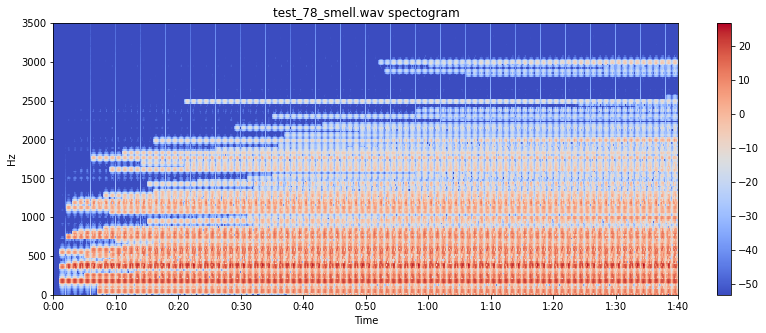

In [269]:
convert_audio_to_spectogram("test_78_smell.wav")

In [ ]:
#### 
# https://towardsdatascience.com/visualization-of-word-embedding-vectors-using-gensim-and-pca-8f592a5d3354
# Unsure why anyone is bothering with doing this manually...
####

'''
# Get list of words in vocab
words=list(model.wv.vocab)
#print(words)

# Get vector representations of all words 
X=model[model.wv.vocab]
df=pd.DataFrame(X) # (X?)
df.shape
df.head()

#Computing the correlation matrix
X_corr=df.corr()

#Computing eigen values and eigen vectors
values,vectors=np.linalg.eig(X_corr)

#Sorting the eigen vectors coresponding to eigen values in descending order
args = (-values).argsort()
values = vectors[args]
vectors = vectors[:, args]

#Taking first 2 components which explain maximum variance for projecting
new_vectors=vectors[:,:2]

#Projecting it onto new dimesion with 2 axis
neww_X=np.dot(X,new_vectors)
'''

'\n# Get list of words in vocab\nwords=list(model.wv.vocab)\n#print(words)\n\n# Get vector representations of all words \nX=model[model.wv.vocab]\ndf=pd.DataFrame(X) # (X?)\ndf.shape\ndf.head()\n\n#Computing the correlation matrix\nX_corr=df.corr()\n\n#Computing eigen values and eigen vectors\nvalues,vectors=np.linalg.eig(X_corr)\n\n#Sorting the eigen vectors coresponding to eigen values in descending order\nargs = (-values).argsort()\nvalues = vectors[args]\nvectors = vectors[:, args]\n\n#Taking first 2 components which explain maximum variance for projecting\nnew_vectors=vectors[:,:2]\n\n#Projecting it onto new dimesion with 2 axis\nneww_X=np.dot(X,new_vectors)\n'